In [1]:
# packages for data analysis

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

# packages for learning
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets

%load_ext autoreload
%autoreload 2

sns.set()

### data prepocessing

In [2]:
##########################################################
#### data importing 
parquet_file = 'TCV_LHD_db4ML.parquet.part'
df = pd.read_parquet(parquet_file, engine ='auto')

##########################################################
#### removing spurious data
mask = df['LDH'] == 'Ip<Ip_MIN'
df_filter = df.drop(index = df[mask].index) #remove Ip<Ip_MIN values 

df_filter = df_filter.dropna() #remove Nan values
df_filter = df_filter.reset_index(drop=True) #reset indexing
df_filter.LDH = df_filter.LDH.cat.remove_categories('Ip<Ip_MIN') #remove Ip<Ip_MIN category

discard_data = len(df.index) - len(df_filter.index) # number of data point that do not contain useful information
print('number of useless data points: ', discard_data)
print('size of filtered data set: ', len(df_filter.index))
print('size of original data set: ', len(df.index))
print(len(df_filter.index) + discard_data - len(df.index))

AttributeError: Can only use .cat accessor with a 'category' dtype

In [3]:
# data statistical description of filtered data set
df_filter.describe()

,time,IP,PD,FIR,WP,pulse
count,2.559098e+06,2.559098e+06,2.559098e+06,2.559098e+06,2.559098e+06,2.559098e+06
mean,8.266415e-01,-1.698241e+05,1.930962e+00,3.095963e+19,9.274230e+03,8.874386e+01
std,5.230307e-01,1.453323e+05,1.525341e+00,1.508287e+19,6.464409e+03,4.975073e+01
min,9.800076e-03,-4.633848e+05,7.812500e-02,-6.358192e+19,-1.856671e+04,1.000000e+00
25%,3.886000e-01,-2.221287e+05,8.544966e-01,2.065296e+19,4.887142e+03,4.700000e+01
50%,7.699001e-01,-1.808367e+05,1.528366e+00,2.895654e+19,7.652717e+03,8.700000e+01
75%,1.213500e+00,-1.425753e+05,2.585706e+00,3.912802e+19,1.314990e+04,1.320000e+02
max,2.530800e+00,4.370332e+05,1.000000e+01,1.196714e+20,4.367435e+04,1.720000e+02


In [4]:
df_filter['LDH'].values

array(['L', 'L', 'L', ..., 'L', 'L', 'L'], dtype=object)

In [5]:
#######################################
### data splitting
def split_data(x, y, ratio=0.90, seed=0):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    # generate random indices
    dataset_size = x.shape[0]
    indices = np.random.permutation(dataset_size)
    threshold  = int(ratio * dataset_size)
    index_train = indices[:threshold]
    index_test = indices[threshold:]
    # create split
    x_training = x[index_train]
    x_test = x[index_test]
    y_training = y[index_train]
    y_test = y[index_test]
    return x_training, x_test, y_training, y_test

In [6]:
df_filter.head()

,time,IP,PD,FIR,WP,LDH,pulse
0,0.0257,50076.167327,1.796861,5.006723e+18,0.0,L,1.0
1,0.0258,50372.816198,1.816465,5.024210e+18,0.0,L,1.0
2,0.0259,50640.227687,2.031274,5.114125e+18,0.0,L,1.0
3,0.0260,50907.639176,1.894527,5.160487e+18,0.0,L,1.0
4,0.0261,51078.462437,1.865220,5.162926e+18,0.0,L,1.0


In [7]:
X = df_filter.drop(['time','LDH','pulse'], axis =1 ).to_numpy()

## labels 
maskl = df_filter.LDH == 'L'
maskd = df_filter.LDH == 'D'
maskh = df_filter.LDH == 'H'

Y = np.vstack((maskl, maskd, maskh)).T + 0.0
Y[10000:10050, :]

print('X shape, ', X.shape)
print('Y shape, ', Y.shape)
print(Y[0,:])

X shape,  (2559098, 4)
Y shape,  (2559098, 3)
[1. 0. 0.]


In [8]:
x_train, x_test, y_train, y_test = split_data(X, Y)

In [9]:
print('x and y train shapes: ', x_train.shape, y_train.shape)
print('x and y test shapes: ', x_test.shape, y_test.shape)

x and y train shapes:  (2303188, 4) (2303188, 3)
x and y test shapes:  (255910, 4) (255910, 3)


In [10]:
x_train

array([[-3.96550125e+05,  1.36720364e+00,  2.41293435e+19,
         1.18902916e+04],
       [-2.45276911e+05,  2.52708005e+00,  2.05771626e+19,
         4.76753728e+03],
       [-1.89175155e+05,  8.54525021e-01,  3.07287242e+19,
         8.03971561e+03],
       ...,
       [-1.74133402e+05,  1.38706174e+00,  2.60728573e+19,
         6.10206483e+03],
       [-1.41622618e+05,  1.85966085e+00,  2.18335347e+19,
         2.86955625e+03],
       [ 4.28700480e+05,  2.65147309e+00,  3.82011180e+19,
         2.15703591e+04]])

#### DEEP LEARNING

In [11]:
#convert  into tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

# trim some samples, THINK HOW TO DEAL WITH THIS
x_train = x_train[:1000000, :]
y_train = y_train[:1000000, :]

x_test = x_test[:200000, :]
y_test = y_test[:200000, :]

In [14]:
x_train.shape

torch.Size([1000000, 4])

Computing SC+BN


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 3, 3, 3], but got 2-dimensional input of size [1, 4] instead

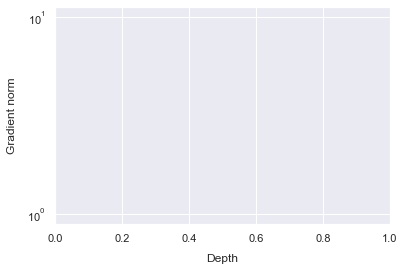

In [15]:
# first architecture with convolutions
######################################################################
train_input = x_train
train_targets = y_train

class ResNetBlock(nn.Module):
    def __init__(self, nb_channels, kernel_size,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv1 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn1 = nn.BatchNorm2d(nb_channels)

        self.conv2 = nn.Conv2d(nb_channels, nb_channels,
                               kernel_size = kernel_size,
                               padding = (kernel_size - 1) // 2)

        self.bn2 = nn.BatchNorm2d(nb_channels)

        self.skip_connections = skip_connections
        self.batch_normalization = batch_normalization

    def forward(self, x):
        y = self.conv1(x)
        if self.batch_normalization: 
            y = self.bn1(y)
        y = F.relu(y)
        y = self.conv2(y)
        if self.batch_normalization: 
            y = self.bn2(y)
        if self.skip_connections: 
            y = y + x
        y = F.relu(y)

        return y

######################################################################

class ResNet(nn.Module):

    def __init__(self, nb_residual_blocks, nb_channels,
                 kernel_size = 3, nb_classes = 3,
                 skip_connections = True, batch_normalization = True):
        super().__init__()

        self.conv = nn.Conv2d(3, nb_channels,
                              kernel_size = kernel_size,
                              padding = (kernel_size - 1) // 2)
        self.bn = nn.BatchNorm2d(nb_channels)

        self.resnet_blocks = nn.Sequential(
            *(ResNetBlock(nb_channels, kernel_size, skip_connections, batch_normalization)
              for _ in range(nb_residual_blocks))
        )

        self.fc = nn.Linear(nb_channels, nb_classes)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.resnet_blocks(x)
        x = F.avg_pool2d(x, 32).view(x.size(0), -1)
        x = self.fc(x)
        return x

######################################################################

def get_stats(skip_connections, batch_normalization, nb_samples = 1000):

    model = ResNet(nb_residual_blocks = 5, nb_channels = 1,
                   kernel_size = 3, nb_classes = 3,
                   skip_connections = skip_connections, batch_normalization = batch_normalization)

    criterion = nn.CrossEntropyLoss()

    monitored_parameters = [ b.conv1.weight for b in model.resnet_blocks ]

    result = torch.empty(len(monitored_parameters), nb_samples)

    for n in range(nb_samples):
        output = model(train_input[n:n+1])
        loss = criterion(output, train_targets[n:n+1])
        model.zero_grad()
        loss.backward()
        for d, p in enumerate(monitored_parameters):
            result[d, n] = p.grad.norm()

    return result

######################################################################

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Depth', labelpad = 10)
ax.set_yscale('log')
ax.set_ylabel('Gradient norm', labelpad = 10)

graph_param = [
    ( True,   True, 'tab:red', 'SC+BN' ),
    ( True,  False, 'tab:green', 'SC' ),
    ( False,  True, 'tab:blue', 'BN' ),
    ( False, False, 'tab:orange', 'None' ),
]

for sc, bn, color, label in graph_param:
    print('Computing ' + label)
    x = get_stats(skip_connections = sc, batch_normalization = bn)
    ax.plot(x.mean(1).numpy(), color = color, label = label)

ax.legend(frameon = True)

plt.show()

In [19]:
# basic architecture with no convolutions
mini_batch_size = 500
######################################################################
def train_model(model, train_input, train_target):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 1e-3, momentum = .9)
    nb_epochs = 1

    for e in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            
######################################################################
def compute_nb_errors(model, data_input, data_target):
    nb_data_errors = 0    
    for b in range(0, data_input.size(0), mini_batch_size):
        output = model(data_input.narrow(0, b, mini_batch_size))    
        _, predicted_classes = torch.max(output, 1)
        #print('', predicted_classes)
        for k in range(mini_batch_size):
            if data_target[b + k] != predicted_classes[k]:
                nb_data_errors = nb_data_errors + 1

    return nb_data_errors

######################################################################

def create_deep_model():
    return nn.Sequential(
        nn.Linear(4, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 50),
        nn.Sigmoid(),
        nn.Linear(50, 3)
    )

In [20]:
for std in [ -1, 1e-3, 1e-2, 1e-1, 1e-0, 1e1 ]:
    for m in [create_deep_model ]:
        model = m()
        if std > 0:
            with torch.no_grad():
                for p in model.parameters(): p.normal_(0, std)
        train_model(model, x_train, y_train)
        #print('std {:s} {:f} train_error {:.02f}% test_error {:.02f}%'.format(
            #m.__name__,
            #std,
            #compute_nb_errors(model, x_train, y_train) / x_train.size(0) * 100),
            #compute_nb_errors(model, x_test, y_test) / x_test.size(0) * 100)


In [21]:
200000/mini_batch_size

400.0

In [22]:
for p in list(model.parameters()):
    print(p)

Parameter containing:
tensor([[ 2.9126e+01, -3.8010e+00, -3.3437e+00,  2.5470e+00],
        [-4.3870e+00, -6.0719e+00, -2.1232e+01,  3.2724e+00],
        [-1.0403e+01,  9.4656e+00, -2.1305e+01, -5.9443e+00],
        [ 6.5603e+00,  2.1872e-01, -9.1958e+00,  2.7545e+00],
        [-1.3754e+01,  1.3556e+01, -1.1218e+01, -2.7523e-02],
        [-7.3830e+00, -1.6159e+01,  1.5713e+00, -5.9635e+00],
        [ 1.9500e+01,  8.2636e+00,  7.1649e+00, -4.9562e+00],
        [ 1.3739e+01, -1.3158e+01,  2.2727e+01,  7.9483e-01],
        [ 1.2672e+01, -1.8844e+01,  1.5588e+01,  1.0660e+00],
        [ 1.5393e+00,  1.6727e+01,  6.0068e+00, -1.6758e+01],
        [-1.1705e+01, -6.8609e-01,  1.6967e+01,  1.5745e+01],
        [ 5.0362e+00,  3.8601e+00,  2.0877e+00, -1.2678e+01],
        [-9.4211e+00,  5.8850e+00, -5.6782e+00,  1.1583e+01],
        [-1.2353e+01,  5.5597e+00, -1.5085e+01, -1.0521e+00],
        [-4.4946e-01,  1.2309e+01, -1.9819e+01,  5.7751e+00],
        [ 9.3257e+00, -2.2640e+01, -1.1894e+01, 

In [23]:
def probability_to_category(prediction):
    prediction['prediction'] = prediction[['H','L','D']].idxmax(axis=1)

In [24]:
df_filter

,time,IP,PD,FIR,WP,LDH,pulse
0,0.0257,50076.167327,1.796861,5.006723e+18,0.0,L,1.0
1,0.0258,50372.816198,1.816465,5.024210e+18,0.0,L,1.0
2,0.0259,50640.227687,2.031274,5.114125e+18,0.0,L,1.0
3,0.0260,50907.639176,1.894527,5.160487e+18,0.0,L,1.0
4,0.0261,51078.462437,1.865220,5.162926e+18,0.0,L,1.0
...,...,...,...,...,...,...,...
2559093,1.6629,-132822.096678,10.000000,-1.714051e+19,0.0,L,172.0
2559094,1.6630,-108659.484245,10.000000,-1.790255e+19,0.0,L,172.0
2559095,1.6631,-86085.879530,10.000000,-1.880538e+19,0.0,L,172.0
2559096,1.6633,-45424.997785,10.000000,-1.626079e+19,0.0,L,172.0


In [25]:
sample = df_filter.iloc[100,0:5]
sample

time                   0.0357
IP               65862.992402
PD                   2.094744
FIR     5816646373113490432.0
WP                        0.0
Name: 100, dtype: object

In [26]:
#prediction = model(torch.tensor(sample).float())
prediction = model(x_test)

In [27]:
#df_filter['L','D','H'] = model(torch.tensor(df_filter[]).float())
x_test.shape

torch.Size([200000, 4])

In [28]:
prediction.shape

torch.Size([200000, 3])

In [29]:
prediction

tensor([[-16.2439, -18.5878, -16.8820],
        [-16.2439, -18.5878, -16.8820],
        [-16.2439, -18.5878, -16.8820],
        ...,
        [-16.2439, -18.5878, -16.8820],
        [-16.2439, -18.5878, -16.8820],
        [-16.2439, -18.5878, -16.8820]], grad_fn=<AddmmBackward0>)

In [30]:
df_expe = {}

for pulse in df_filter['pulse'].unique():

    df_expe[pulse] = df_filter[  df_filter['pulse'] == pulse ]
    
len(df_expe)

172

In [34]:
window_size=20
from tqdm import tqdm
pictures = []

for i in tqdm(range(1,20)):
    number_of_cuts = np.floor(len(df_expe[i]) / window_size)
    ls = list(range(1 , int(number_of_cuts)+1)) 
    ls_array = np.array(ls)
    cuts = ls_array * window_size

    df_splited = np.array_split(df_expe[i], cuts)
    df_splited.pop()
    
    for j in range(0,len(df_splited)):
        pictures.append(df_splited[j])

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 51.58it/s]


In [35]:
pictures[18]


,time,IP,PD,FIR,WP,LDH,pulse
360,0.0617,103370.152940,1.943361,8.324861e+18,-9397.081516,L,1.0
361,0.0618,103668.464296,1.933573,8.360242e+18,-10222.959015,L,1.0
362,0.0619,103957.620654,1.904300,8.419808e+18,-11048.836515,L,1.0
363,0.0620,104246.775915,1.845702,8.413600e+18,-11874.714014,L,1.0
364,0.0621,104402.621874,1.860332,8.535899e+18,-11015.464386,L,1.0
365,0.0622,104558.447361,1.850596,8.541390e+18,-10155.955981,L,1.0
366,0.0623,104822.278374,1.894563,8.569250e+18,-9296.447576,L,1.0
367,0.0624,105086.127441,1.835948,8.592190e+18,-8436.939172,L,1.0
368,0.0625,105321.447676,1.933563,8.669182e+18,-7577.430767,L,1.0
369,0.0626,105556.770175,1.860382,8.711939e+18,-6717.922362,L,1.0


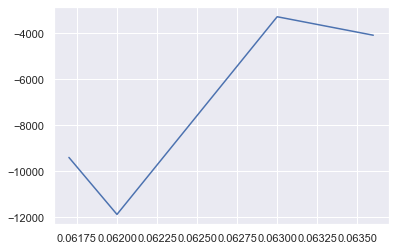

In [48]:
import matplotlib.pyplot as plt
plt.plot(pictures[18]['time'], pictures[18]['WP'])
plt.show()


### Fourrier Transform

In [58]:
from scipy.fft import fft, fftfreq

def fourrier(df):
    for i in ['IP','PD','FIR','WP']:
        df[i+'_f'] = np.abs(np.fft.fft(pictures[18][i]))
    #xf = fftfreq(N, 1 / SAMPLE_RATE)


In [59]:
fourrier(pictures[18])
pictures[18]

,time,IP,PD,FIR,WP,LDH,pulse,IP_f,PD_f,FIR_f,WP_f
360,0.0617,103370.152940,1.943361,8.324861e+18,-9397.081516,L,1.0,2.113407e+06,37.758810,1.738411e+20,136512.543478
361,0.0618,103668.464296,1.933573,8.360242e+18,-10222.959015,L,1.0,1.498720e+04,0.232436,2.294339e+18,40203.454123
362,0.0619,103957.620654,1.904300,8.419808e+18,-11048.836515,L,1.0,7.083566e+03,0.136042,1.027607e+18,9695.563930
363,0.0620,104246.775915,1.845702,8.413600e+18,-11874.714014,L,1.0,5.128214e+03,0.177188,8.467825e+17,6232.219018
364,0.0621,104402.621874,1.860332,8.535899e+18,-11015.464386,L,1.0,3.946739e+03,0.040080,5.651189e+17,3678.394157
365,0.0622,104558.447361,1.850596,8.541390e+18,-10155.955981,L,1.0,3.439247e+03,0.069967,4.002335e+17,2568.864356
366,0.0623,104822.278374,1.894563,8.569250e+18,-9296.447576,L,1.0,2.778532e+03,0.147737,5.174468e+17,3070.533848
367,0.0624,105086.127441,1.835948,8.592190e+18,-8436.939172,L,1.0,2.537659e+03,0.170914,4.809047e+17,3545.649333
368,0.0625,105321.447676,1.933563,8.669182e+18,-7577.430767,L,1.0,2.445296e+03,0.111866,4.531251e+17,2662.072687
369,0.0626,105556.770175,1.860382,8.711939e+18,-6717.922362,L,1.0,2.360671e+03,0.121586,3.802102e+17,2228.939336
